In [1]:
!pip install pmdarima --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.4 MB/s eta 0:00:00


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"madhurvp","key":"c83b896293dd89b4e341625407cb69a6"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d berkeleyearth/climate-change-earth-surface-temperature-data

!unzip climate-change-earth-surface-temperature-data.zip

Dataset URL: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data
License(s): CC-BY-NC-SA-4.0
Archive:  climate-change-earth-surface-temperature-data.zip
  inflating: GlobalLandTemperaturesByCity.csv  
  inflating: GlobalLandTemperaturesByCountry.csv  
  inflating: GlobalLandTemperaturesByMajorCity.csv  
  inflating: GlobalLandTemperaturesByState.csv  
  inflating: GlobalTemperatures.csv  


In [5]:
import pandas as pd

df = pd.read_csv('GlobalLandTemperaturesByCity.csv', parse_dates=['dt'])
df = df.dropna(subset=['AverageTemperature'])
df['YearMonth'] = df['dt'].dt.to_period('M').dt.to_timestamp()

monthly_global = df.groupby('YearMonth')['AverageTemperature'].mean().reset_index()
monthly_global.set_index('YearMonth', inplace=True)

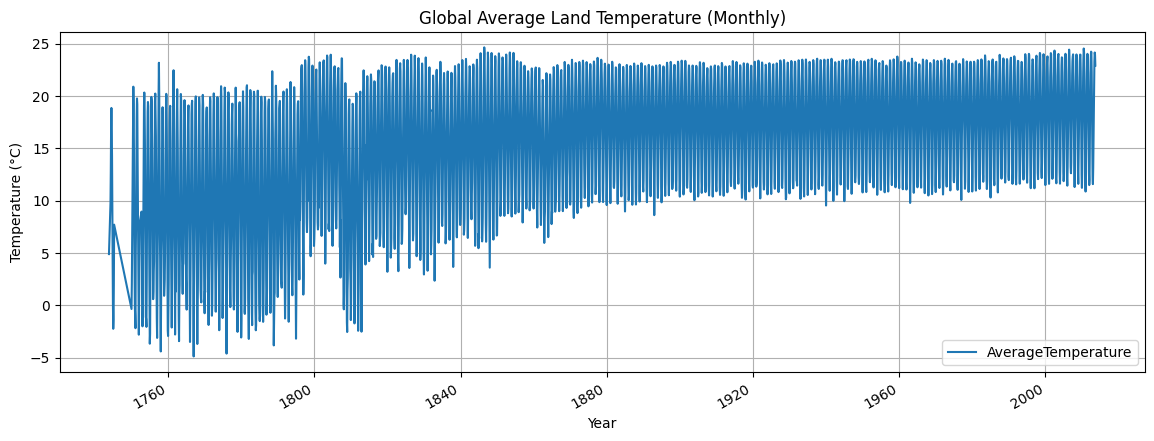

In [6]:
# Step 5: Visualize
import matplotlib.pyplot as plt
monthly_global.plot(figsize=(14, 5), title="Global Average Land Temperature (Monthly)")
plt.ylabel("Temperature (°C)")
plt.xlabel("Year")
plt.grid(True)
plt.show()

In [7]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(monthly_global['AverageTemperature'], order=(3, 1, 2))
fitted_model = model.fit()

print(fitted_model.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:     AverageTemperature   No. Observations:                 3167
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -4837.664
Date:                Fri, 11 Apr 2025   AIC                           9687.328
Time:                        15:59:53   BIC                           9723.689
Sample:                             0   HQIC                          9700.371
                               - 3167                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5513      0.010    157.861      0.000       1.532       1.571
ar.L2         -0.6918      0.017    -41.484      0.000      -0.725      -0.659
ar.L3         -0.1717      0.010    -17.712      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


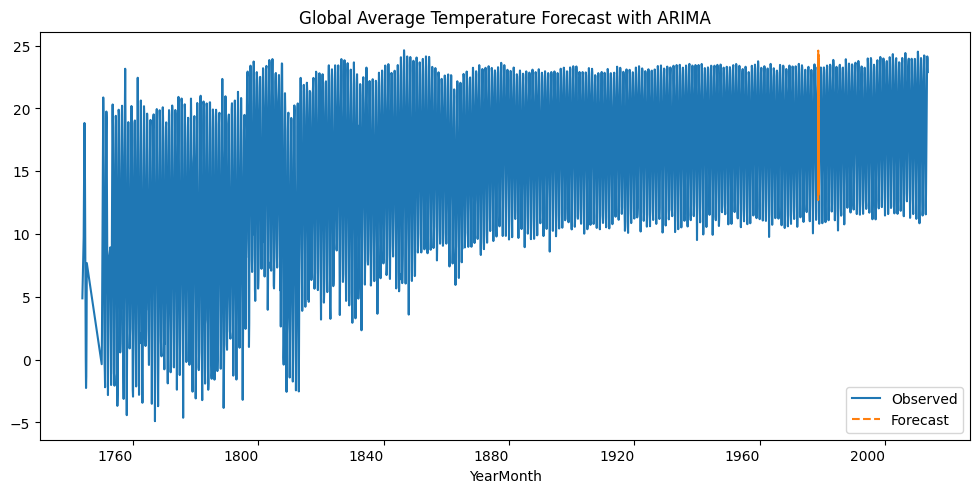

In [8]:
forecast = fitted_model.forecast(steps=36)
monthly_global['AverageTemperature'].plot(label='Observed', figsize=(12, 6))
forecast.plot(label='Forecast', linestyle='--')
plt.legend()
plt.title("Global Average Temperature Forecast with ARIMA")
plt.show()

<Axes: title={'center': 'ARIMA Residuals'}, xlabel='YearMonth'>

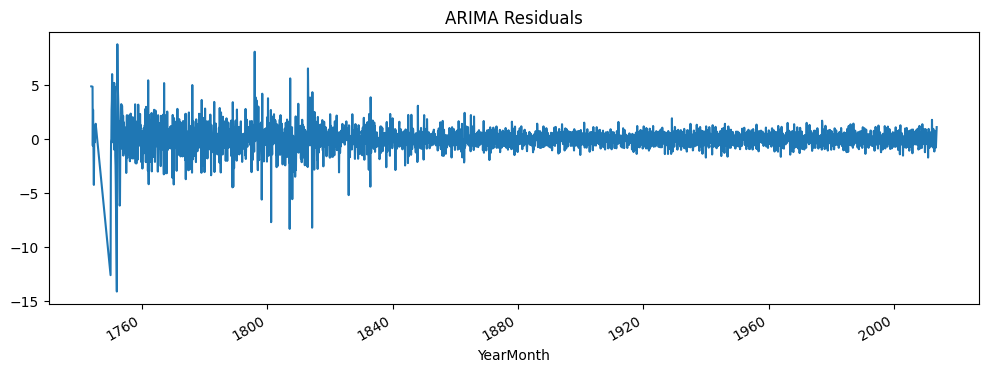

In [9]:
residuals = fitted_model.resid
residuals = residuals.dropna()
residuals.plot(title="ARIMA Residuals", figsize=(12, 4))

In [10]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
residuals_scaled = scaler.fit_transform(residuals.values.reshape(-1, 1))

def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        y.append(data[i + window])
    return np.array(X), np.array(y)

window_size = 12
X, y = create_sequences(residuals_scaled, window_size)

X = X.reshape((X.shape[0], X.shape[1], 1))

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, input_shape=(window_size, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=20, batch_size=32)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0657
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0024
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0030
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0024
Epoch 9/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027
Epoch 10/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0027
Epoch 11/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0025
Epoch 12/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0027
Epoch 13/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0024
Epoch 14/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028
Epoch 15/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0026
Epoch 16/20
99/99 ━━━━━━━━━━━━

In [12]:
last_seq = residuals_scaled[-window_size:]
predicted_residuals = []

for _ in range(36):
    input_seq = last_seq.reshape((1, window_size, 1))
    next_res = model.predict(input_seq, verbose=0)
    predicted_residuals.append(next_res[0, 0])
    last_seq = np.append(last_seq[1:], next_res)

predicted_residuals = scaler.inverse_transform(np.array(predicted_residuals).reshape(-1, 1)).flatten()

In [15]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
temp_scaled = scaler.fit_transform(monthly_global[['AverageTemperature']])

lookback = 12
X_scaled, y_scaled = [], []

for i in range(lookback, len(temp_scaled)):
    X_scaled.append(temp_scaled[i - lookback:i])
    y_scaled.append(temp_scaled[i])

X_scaled, y_scaled = np.array(X_scaled), np.array(y_scaled)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


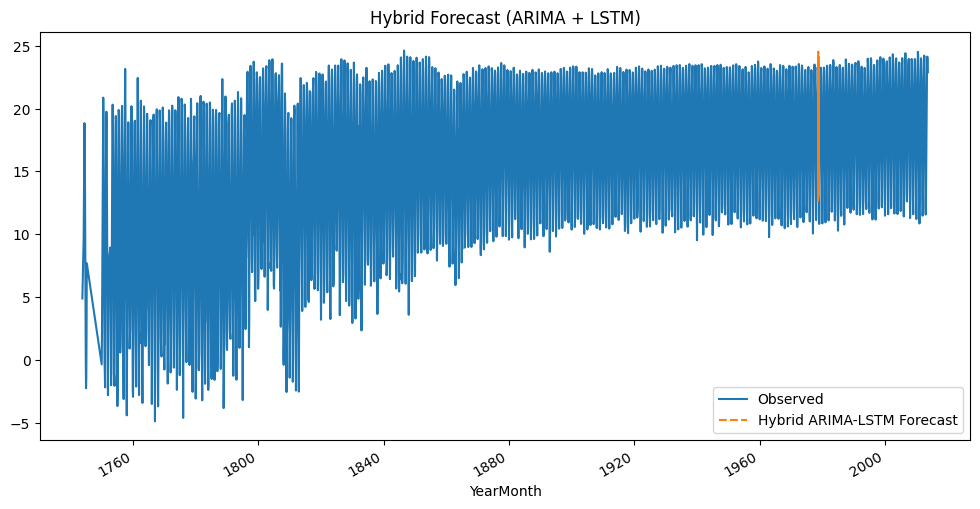

In [17]:
split = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train, y_test = y_scaled[:split], y_scaled[split:]

arima_forecast = fitted_model.forecast(steps=len(predicted_residuals))
hybrid_forecast = arima_forecast + predicted_residuals


plt.figure(figsize=(12, 6))
monthly_global['AverageTemperature'].plot(label='Observed')
plt.plot(arima_forecast.index, hybrid_forecast, label='Hybrid ARIMA-LSTM Forecast', linestyle='--')
plt.legend()
plt.title("Hybrid Forecast (ARIMA + LSTM)")
plt.show()


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, input_shape=(window_size, 1), return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X, y, epochs=20, batch_size=32, verbose=1)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1171
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0026
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0025
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0025
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0023
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025
Epoch 9/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0025
Epoch 10/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023
Epoch 11/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0025
Epoch 12/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0027
Epoch 13/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023
Epoch 14/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0024
Epoch 15/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027
Epoch 16/20
99/99 ━━━━━━━━━━━━

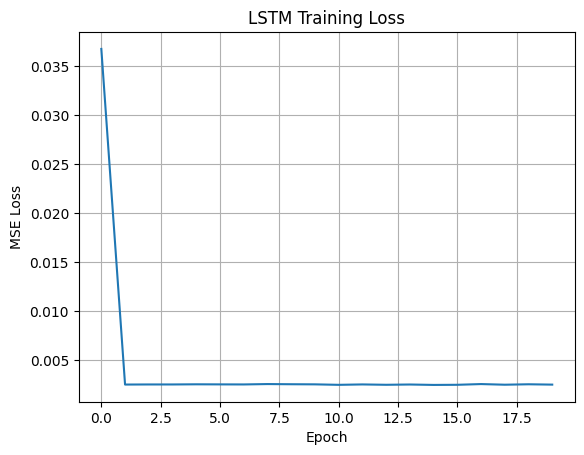

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title("LSTM Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

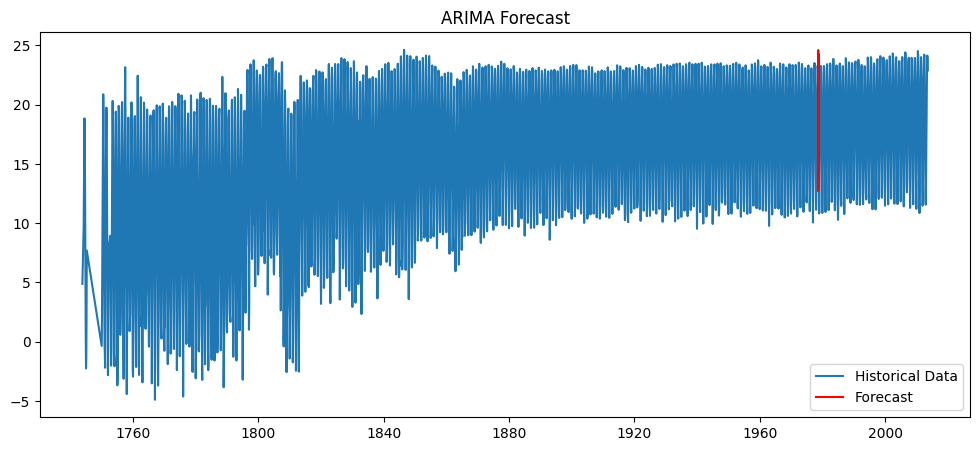

In [20]:
n_forecast = 36
plt.figure(figsize=(12, 5))
plt.plot(monthly_global['AverageTemperature'], label='Historical Data')
plt.plot(range(len(monthly_global), len(monthly_global) + n_forecast), forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

In [21]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler


values = monthly_global['AverageTemperature'].values.reshape(-1, 1)


scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(values)


def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Choose sequence length
sequence_length = 30
X, y = create_sequences(scaled_values, sequence_length)

# Train/test split (80/20)
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (2509, 30, 1), Test shape: (628, 30, 1)


In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.3068 - val_loss: 0.0238
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0394 - val_loss: 0.0121
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0197 - val_loss: 0.0101
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0062 - val_loss: 0.0014
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0026 - val_loss: 3.8381e-04
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - val_loss: 7.2164e-04
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - val_loss: 3.8458e-04
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018 - val_loss: 2.9495e-04
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - val_loss: 2.9768e-04
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - val_loss: 7.7440e-04
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - los

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


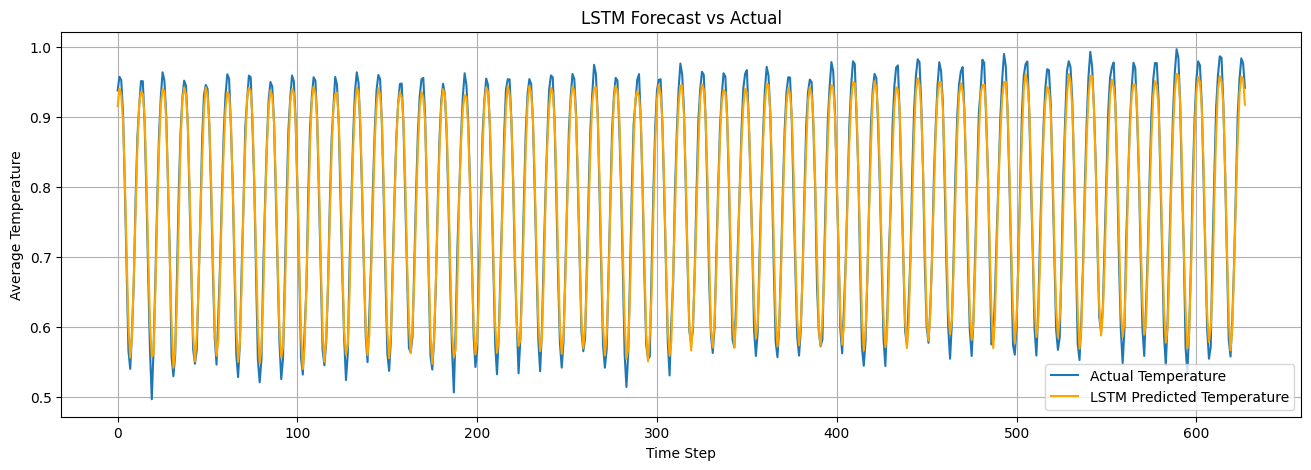

In [55]:
# Make predictions
lstm_predictions = model.predict(X_test[:len(y_test)])

# Plot actual vs predicted
plt.figure(figsize=(16, 5))
plt.plot(y_test, label='Actual Temperature')
plt.plot(lstm_predictions, label='LSTM Predicted Temperature', color='orange')
plt.title('LSTM Forecast vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Average Temperature')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
from sklearn.metrics import mean_squared_error
import numpy as np

# ARIMA RMSE (using previous ARIMA forecast)
arima_rmse = np.sqrt(mean_squared_error(y_test[:len(arima_forecast)], arima_forecast))

# LSTM RMSE
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))

print(f"ARIMA RMSE: {arima_rmse:.4f}")
print(f"LSTM RMSE: {lstm_rmse:.4f}")

ARIMA RMSE: 18.3895
LSTM RMSE: 0.0212


In [28]:
# y_test_flat = y_test.squeeze()  # safely flattens if it's (628, 1) or (628, 628)
# arima_forecast_flat = arima_forecast.squeeze()

# # Truncate y_test to match the forecast length
# y_test_aligned = y_test[:len(arima_forecast)]

# predicted_residuals = y_test_aligned - arima_forecast
# residual_correction = model.predict(X_test)    # LSTM predicts the residual
# hybrid_forecast = arima_forecast + residual_correction

# Align and flatten everything
y_test_flat = y_test.squeeze()
arima_forecast_flat = arima_forecast.squeeze()
y_test_aligned = y_test_flat[:len(arima_forecast_flat)]

# Calculate residuals and LSTM correction
predicted_residuals = y_test_aligned - arima_forecast_flat

residual_correction_raw = model.predict(X_test)[:len(arima_forecast_flat)]
residual_correction = residual_correction_raw.squeeze()  # Ensure 1D shape

# Final hybrid forecast
hybrid_forecast = arima_forecast_flat + residual_correction

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


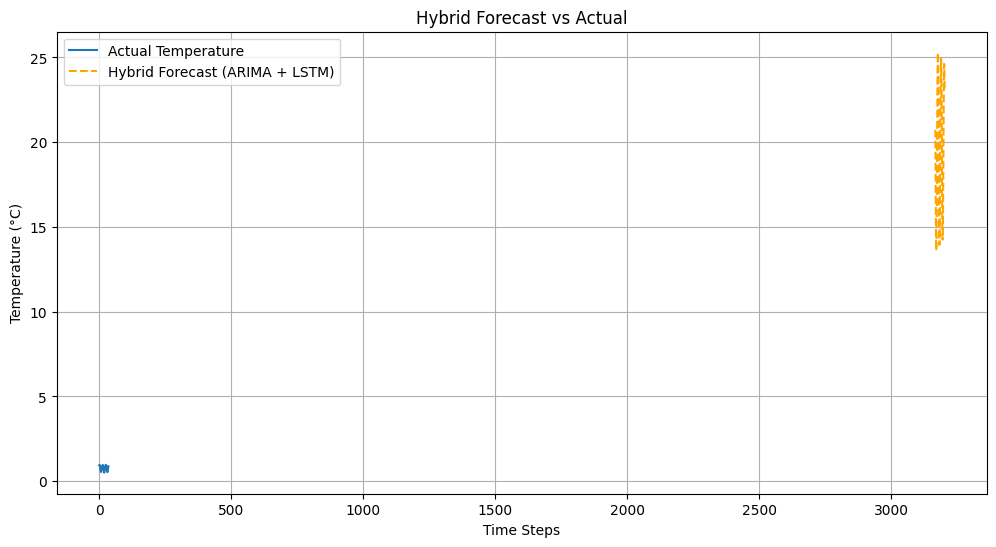

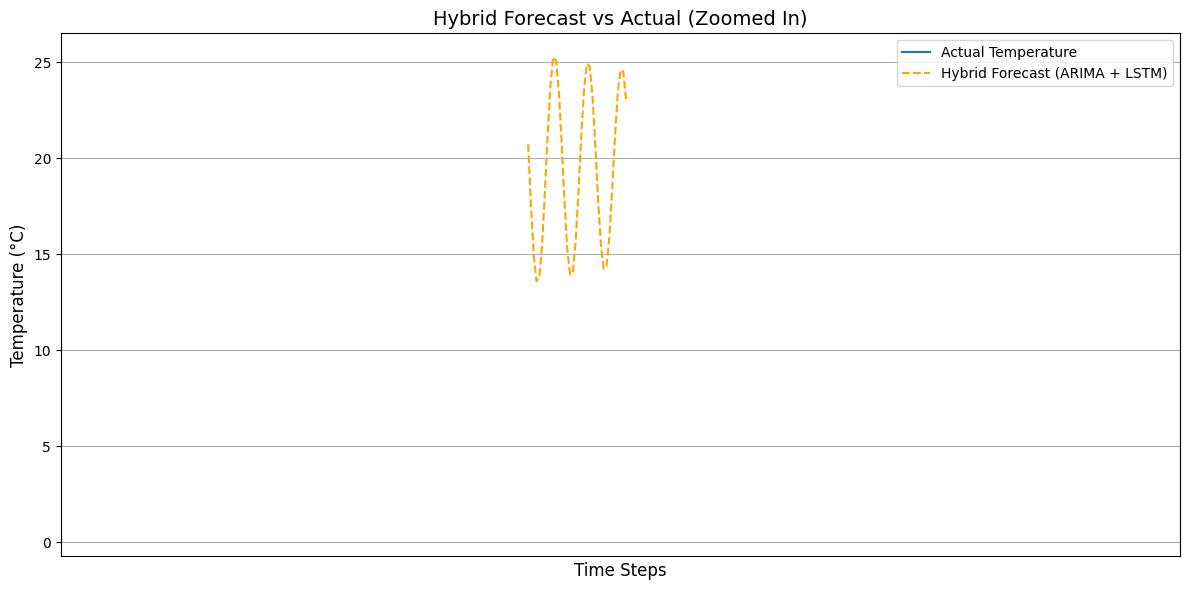

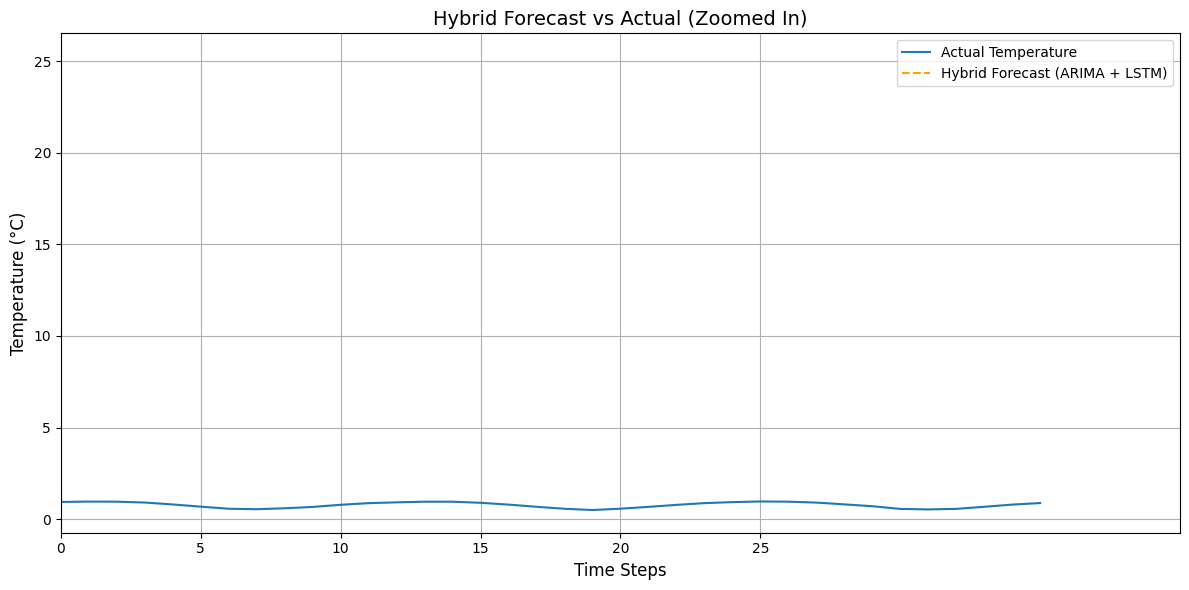

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_aligned, label='Actual Temperature')
plt.plot(hybrid_forecast, label='Hybrid Forecast (ARIMA + LSTM)', linestyle='--', color='orange')
plt.title('Hybrid Forecast vs Actual')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()
print()

plt.figure(figsize=(12, 6))
plt.plot(y_test_aligned, label='Actual Temperature')
plt.plot(hybrid_forecast, label='Hybrid Forecast (ARIMA + LSTM)', linestyle='--', color='orange')

plt.title('Hybrid Forecast vs Actual (Zoomed In)', fontsize=14)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)

plt.xticks(ticks=np.arange(0, 30, 5))  # Every 5 steps in zoom
plt.xlim(3000, 3400)  # Only show first 30 points
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print()

plt.figure(figsize=(12, 6))
plt.plot(y_test_aligned, label='Actual Temperature')
plt.plot(hybrid_forecast, label='Hybrid Forecast (ARIMA + LSTM)', linestyle='--', color='orange')

plt.title('Hybrid Forecast vs Actual (Zoomed In)', fontsize=14)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)

plt.xticks(ticks=np.arange(0, 30, 5))  # Every 5 steps in zoom
plt.xlim(0, 40)  # Only show first 30 points
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [34]:
from sklearn.metrics import mean_squared_error
import numpy as np

# RMSEs
arima_rmse = np.sqrt(mean_squared_error(y_test_aligned, arima_forecast_flat))
lstm_rmse = np.sqrt(mean_squared_error(y_test_aligned, residual_correction))
hybrid_rmse = np.sqrt(mean_squared_error(y_test_aligned, hybrid_forecast))

print(f"ARIMA RMSE: {arima_rmse:.4f}")
print(f"LSTM Residual RMSE: {lstm_rmse:.4f}")
print(f"Hybrid Model RMSE: {hybrid_rmse:.4f}")

ARIMA RMSE: 18.3895
LSTM Residual RMSE: 0.0226
Hybrid Model RMSE: 19.1234


In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# RMSEs
arima_rmse = np.sqrt(mean_squared_error(y_test_aligned, arima_forecast_flat))
lstm_rmse = np.sqrt(mean_squared_error(y_test_aligned, residual_correction))
hybrid_rmse = np.sqrt(mean_squared_error(y_test_aligned, hybrid_forecast))

# MAEs
arima_mae = mean_absolute_error(y_test_aligned, arima_forecast_flat)
lstm_mae = mean_absolute_error(y_test_aligned, residual_correction)
hybrid_mae = mean_absolute_error(y_test_aligned, hybrid_forecast)

# Print results
print(f"ARIMA RMSE: {arima_rmse:.4f} | MAE: {arima_mae:.4f}")
print(f"LSTM Residual RMSE: {lstm_rmse:.4f} | MAE: {lstm_mae:.4f}")
print(f"Hybrid Model RMSE: {hybrid_rmse:.4f} | MAE: {hybrid_mae:.4f}")


ARIMA RMSE: 18.3895 | MAE: 17.9243
LSTM Residual RMSE: 0.0226 | MAE: 0.0188
Hybrid Model RMSE: 19.1234 | MAE: 18.6906
